# Building an Equity Universe with Fama-French 5 Factors

<a href="" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<!-- @import "[TOC]" {cmd="toc" depthFrom=1 depthTo=6 orderedList=false} -->

![]()



## Prepare your Environment

Have a jupyter environment ready, and `pip install` these libraries:
- numpy
- pandas
- yfinance

You'll need access to [analysis_utils](./analysis_utils.py) library for common functions.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

import dotenv
%load_ext dotenv

import warnings
warnings.filterwarnings("ignore")

IS_KAGGLE = os.getenv('IS_KAGGLE', 'True') == 'True'

if IS_KAGGLE:
    # Kaggle confgs
    print('Running in Kaggle...')
    %pip install yfinance
    %pip install statsmodels
    %pip install seaborn
    %pip install itertools
    %pip install scikit-learn

    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
else:
    print('Running Local...')

import yfinance as yf
from analysis_utils import load_ticker_prices_ts_df, load_ticker_ts_df

Running in Kaggle...
  Obtaining dependency information for yfinance from https://files.pythonhosted.org/packages/09/82/5a5eee685095a6c1f8968db75bba8536baa8046c970be25e1ac91a843839/yfinance-0.2.33-py2.py3-none-any.whl.metadata
  Obtaining dependency information for lxml>=4.9.1 from https://files.pythonhosted.org/packages/8f/0a/49e5ad85f6841737b39de1f291508716863786940ae031a982392c7d8da7/lxml-5.0.0-cp39-cp39-win_amd64.whl.metadata
  Obtaining dependency information for frozendict>=2.3.4 from https://files.pythonhosted.org/packages/9d/e8/9b079528d31963ded36ec93511e103c19056aa77cff4b9f99ebaa1f7f5ee/frozendict-2.3.10-cp39-cp39-win_amd64.whl.metadata
     ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
     ---------------------------------------- 0.0/2.9 MB 1.4 MB/s eta 0:00:03
      --------------------------------------- 0.1/2.9 MB 656.4 kB/s eta 0:00:05
     -- ------------------------------------- 0.2/2.9 MB 1.3 MB/s eta 0:00:03
     ---- -----------------------------

ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools


Note: you may need to restart the kernel to use updated packages.


Before we start, let's load two uncorrelated securities from the latest post-covid market regime (2020-2023) to build a test portfolio:

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


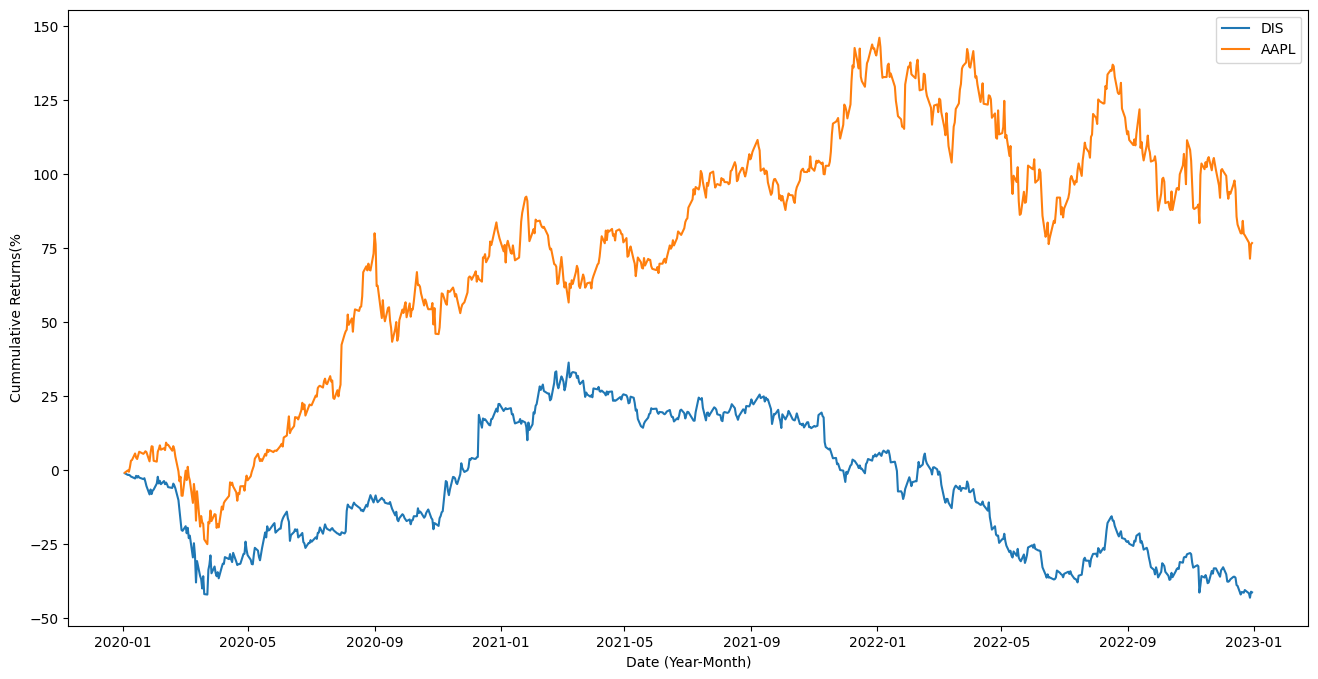

In [2]:
tickers = ["DIS", "AAPL"]

START_DATE = "2020-01-01"
END_DATE = "2022-12-31"

tickers_orig_df = load_ticker_prices_ts_df(tickers, START_DATE, END_DATE)
tickers_df = tickers_orig_df.dropna(axis=1).pct_change().dropna()  # first % is NaN

# 1+ to allow the cumulative product of returns over time, and -1 to remove it at the end.
tickers_df = (1 + tickers_df).cumprod() - 1

plt.figure(figsize=(16, 8))
for ticker in tickers_df.columns:
    plt.plot(tickers_df.index, tickers_df[ticker] * 100.0, label=ticker)

plt.xlabel("Date (Year-Month)")
plt.ylabel("Cummulative Returns(%")
plt.legend()
plt.show()

# Conclusion




![]()

## References

- 


## Github

Article here is also available on [Github]()

Kaggle notebook available [here]()


## Media

All media used (in the form of code or images) are either solely owned by me, acquired through licensing, or part of the Public Domain and granted use through Creative Commons License.

## CC Licensing and Use

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.